## Imports

In [1]:
import sympy
import numpy as np
import matplotlib.pyplot as plt
sympy.init_printing()
from sympy import *
from functools import reduce

## Functions

In [2]:
def plot_polygon(poly: sympy.Polygon, labels = []):
    # Draw a polygon by plotting vertices as points and edges as lines
    fig = plt.figure()
    ax = fig.gca()

    verts = poly.vertices

    for i, p in enumerate(verts):
        ax.scatter(p.x, p.y, c="r")
        if labels:
            plt.text(p.x + 0.05, p.y + 0.05, f"{labels[i]}: ({p.x},{p.y})")
        else:
            plt.text(p.x + 0.05, p.y + 0.05, f"({p.x},{p.y})")

    for (p, nextp) in zip(verts, verts[1:] + verts[:1]):
        x = np.linspace(float(p.x), float(nextp.x), 100, dtype=float)
        y = np.linspace(float(p.y), float(nextp.y), 100, dtype=float)
        ax.plot(x, y, c="b")

    ax.axis("equal")

    plt.show()    

In [3]:
def generate_premise(lines: dict, traj_expr):
    lines_rel = make_relative(lines, traj_expr)
    premise = True
    for line_rel in lines_rel.values():
        premise &= line_rel
    return premise

def generate_explicit(corner_pairs: list, traj, verts):
    explicit = False
    for c1, c2 in corner_pairs:
        corner_traj_1 = expand(traj.subs(y, yo - verts[c1].y).subs(x, xo - verts[c1].x))
        corner_traj_2 = expand(traj.subs(y, yo - verts[c2].y).subs(x, xo - verts[c2].x))
        pair_clause = corner_traj_1 * corner_traj_2 <= 0
        explicit |= pair_clause
    return explicit

def sympy_to_pvs(clause: str):
    if type(clause) is not str:
        clause = str(clause)
    return clause.replace("x_O", "xo").replace("y_O", "yo").replace("|", "OR\n   ").replace("&", "AND\n    ").replace("**", "^")

def construct_lemma(premise, active_corner_condition, lemma_name):
    return f"""{lemma_name}(xo, yo, alpha: real) : bool =
    (EXISTS (x : real) :
    ({sympy_to_pvs(str(premise))})
    IMPLIES
    {sympy_to_pvs(str(active_corner_condition))}
    """

def full_lemma(poly, vert_names, corner_pairs, traj, traj_expr=None, lemma_name="Soundness"):
    if type(vert_names) is str:
        vert_names = vert_names.split()
    assert type(vert_names) is list
    verts, lines = verts_and_lines(vert_names, poly)
    
    premise = generate_premise(lines, traj_expr)
    explicit = generate_explicit(corner_pairs, traj, verts)
    return construct_lemma(premise, explicit, lemma_name)

In [4]:
def build_line(x, y, coefs):
    return x*coefs[0] + y*coefs[1] + coefs[2]

def make_relative(expr, traj_expr):
    if type(expr) == dict:
        return make_relative_dict(expr, traj_expr)
    if traj_expr is None:
        return expr.subs(x, xo - x).subs(y, yo - alpha*x)
    else:
        return expr.subs(x, xo - x).subs(y, yo - traj_expr)

def make_relative_dict(d, te):
    return {k:make_relative(v, te) for k, v in d.items()}

In [5]:
def verts_and_lines(vert_names: list[str], poly: Polygon):
    assert len(vert_names) == len(poly.vertices)
    verts: dict = dict(zip(vert_names, poly.vertices))
    vert_names = sorted(vert_names)
    vert_pairs: list = list(zip(vert_names, vert_names[1:] + vert_names[0:1]))  
    lines: dict = {}
    for i, (vert1, vert2) in enumerate(vert_pairs, 1):
        line = build_line(x, y, Line(verts[vert1], verts[vert2]).coefficients)
        # sub in (0,0) to find inequality direction
        if (line >= 0).subs([(x,0), (y,0)]):
            lines[i] = line >= 0
        else:
            lines[i] = line <= 0
    return verts, lines

## Experimentation

In [6]:
x, y = symbols("x y")
x, y

In [7]:
xo, yo, alpha = symbols(["x_O", "y_O", "alpha"])
xo, yo, alpha

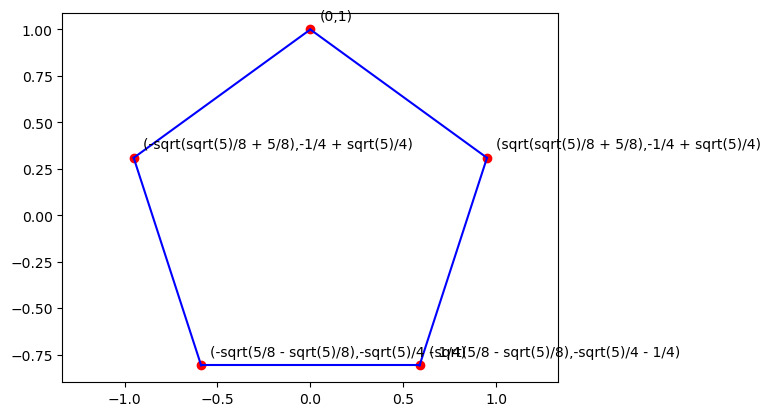

In [8]:
regpent = sympy.RegularPolygon(Point2D(0, 0), 1, 5, pi/2)
plot_polygon(regpent)

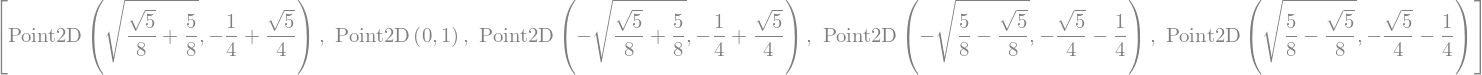

In [9]:
regpent.vertices

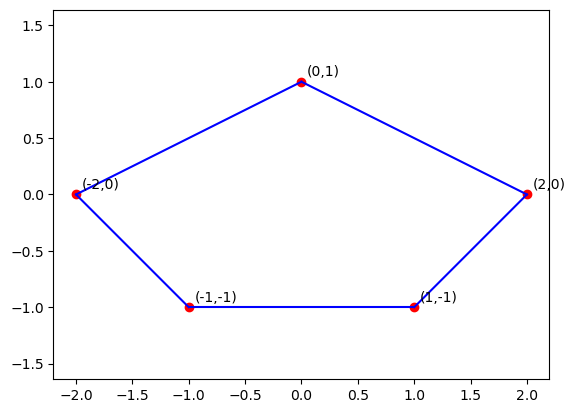

In [10]:
intvertices = [(1, -1), (2, 0), (0, 1), (-2, 0), (-1, -1)]
easypent = Polygon(*intvertices)
plot_polygon(easypent)

In [11]:
verts, lines = verts_and_lines("a b c d e".split(), easypent)
make_relative(lines)

TypeError: make_relative() missing 1 required positional argument: 'traj_expr'

In [13]:
print(full_lemma(easypent, 
                 "b c d e a".split(), 
                 [('a', 'c'), ('a', 'd'), ('b', 'd'), ('b', 'e'), ('c', 'e')], 
                 y - alpha*x))

Soundness(xo, yo, alpha: real) : bool =
    (EXISTS (x : real) :
    ((-alpha*x + yo + 1 >= 0) AND
     (-alpha*x - x + xo + yo + 2 >= 0) AND
     (-alpha*x + x - xo + yo + 2 >= 0) AND
     (2*alpha*x - x + xo - 2*yo + 2 >= 0) AND
     (2*alpha*x + x - xo - 2*yo + 2 >= 0))
    IMPLIES
    ((-alpha*xo + yo - 1)*(-alpha*xo + alpha + yo + 1) <= 0) OR
    ((-alpha*xo - 2*alpha + yo)*(-alpha*xo + alpha + yo + 1) <= 0) OR
    ((-alpha*xo + yo - 1)*(-alpha*xo - alpha + yo + 1) <= 0) OR
    ((-alpha*xo - 2*alpha + yo)*(-alpha*xo + 2*alpha + yo) <= 0) OR
    ((-alpha*xo + 2*alpha + yo)*(-alpha*xo - alpha + yo + 1) <= 0)
    


In [14]:
simplify(expand((2*yo + xo - 2)*(2*alpha - 1) >= (2*yo - xo -2) * (2*alpha+1)))

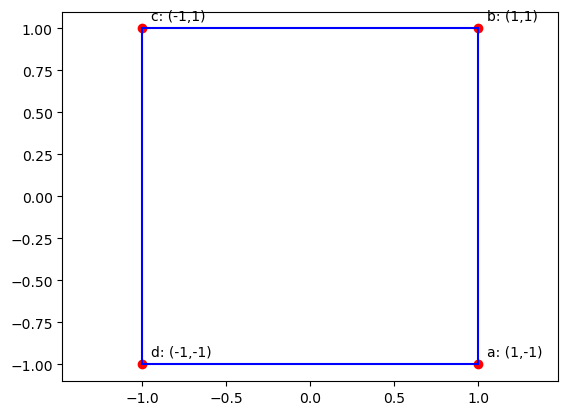

In [15]:
square = RegularPolygon(Point2D(0, 0), sqrt(2), 4, pi/4)
plot_polygon(square, "b c d a".split())
square.vertices

In [16]:
vertex_dict = dict(zip("b c d a".split(), square.vertices))
vertex

NameError: name 'vertex' is not defined

In [17]:
verts, lines = verts_and_lines("b c d a".split(), square)
verts

{'b': Point2D(1, 1),
 'c': Point2D(-1, 1),
 'd': Point2D(-1, -1),
 'a': Point2D(1, -1)}

In [18]:
lines

In [19]:
lines_rel = make_relative(lines)
lines_rel

TypeError: make_relative() missing 1 required positional argument: 'traj_expr'

In [20]:
print(full_lemma(square, "b c d a".split(), [('a', 'c'), ('b', 'd')], y - alpha*x))

Soundness(xo, yo, alpha: real) : bool =
    (EXISTS (x : real) :
    ((-x + xo + 1 >= 0) AND
     (-x + xo - 1 <= 0) AND
     (-alpha*x + yo + 1 >= 0) AND
     (-alpha*x + yo - 1 <= 0))
    IMPLIES
    ((-alpha*xo - alpha + yo - 1)*(-alpha*xo + alpha + yo + 1) <= 0) OR
    ((-alpha*xo - alpha + yo + 1)*(-alpha*xo + alpha + yo - 1) <= 0)
    


In [21]:
solve(lines_rel[4], x)

NameError: name 'lines_rel' is not defined

In [22]:
# def solve_lines(lines: dict):
#     newlines = {}
#     for k in lines.keys():
#         newlines[k] = 

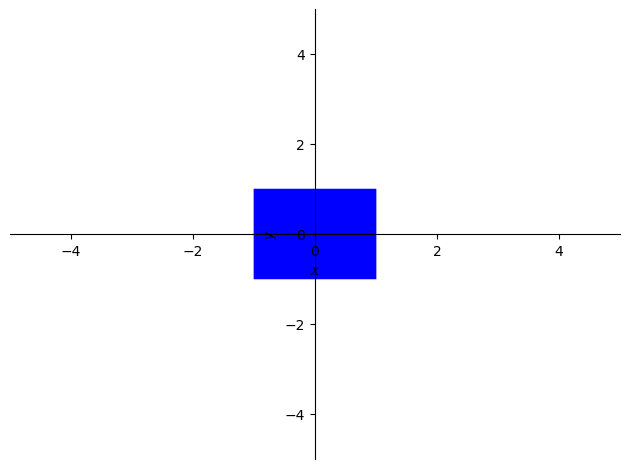

In [23]:
plot_implicit(reduce(lambda x, y: x & y, lines.values()))

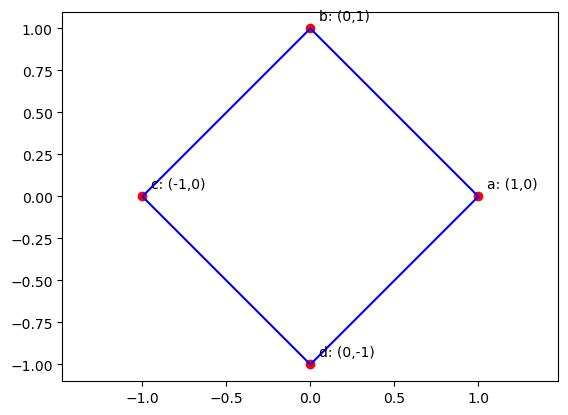

In [24]:
diamond = RegularPolygon(Point2D(0, 0), 1, 4, pi/2)
plot_polygon(diamond, "a b c d".split())
diamond.vertices

In [25]:
print(full_lemma(diamond, "a b c d".split(), [('a', 'c'), ('b', 'd')], y - alpha*x))

Soundness(xo, yo, alpha: real) : bool =
    (EXISTS (x : real) :
    ((-alpha*x - x + xo + yo + 1 >= 0) AND
     (-alpha*x + x - xo + yo + 1 >= 0) AND
     (alpha*x - x + xo - yo + 1 >= 0) AND
     (alpha*x + x - xo - yo + 1 >= 0))
    IMPLIES
    ((-alpha*xo + yo - 1)*(-alpha*xo + yo + 1) <= 0) OR
    ((-alpha*xo - alpha + yo)*(-alpha*xo + alpha + yo) <= 0)
    


In [26]:
verts, lines = verts_and_lines("a b c d".split(), diamond)
verts

{'a': Point2D(1, 0),
 'b': Point2D(0, 1),
 'c': Point2D(-1, 0),
 'd': Point2D(0, -1)}

In [27]:
lines

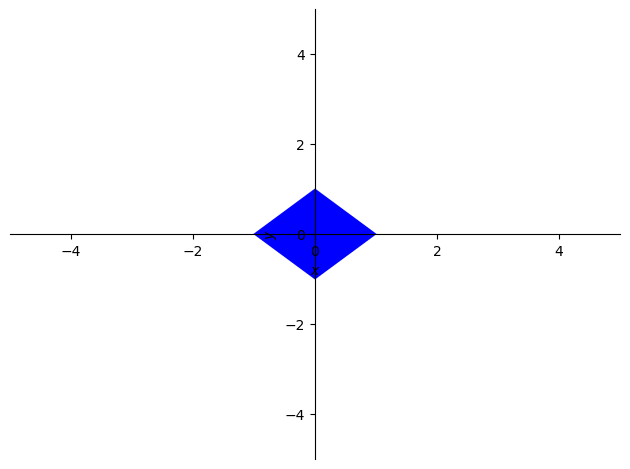

In [28]:
plot_implicit(reduce(lambda x, y: x & y, lines.values()))

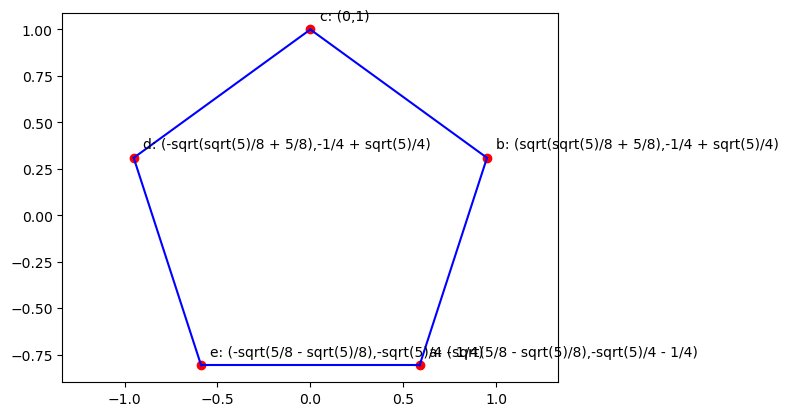

In [29]:
plot_polygon(regpent, "b c d e a".split())

In [30]:
print(full_lemma(regpent, "b c d e a".split(), [('a', 'c'), ('a', 'd'), ('b', 'd'), ('b', 'e'), ('c', 'e')], y - alpha*x))

Soundness(xo, yo, alpha: real) : bool =
    (EXISTS (x : real) :
    ((-alpha*x + yo + 1/4 + sqrt(5)/4 >= 0) AND
     ((-5/4 + sqrt(5)/4)*(-x + xo) - sqrt(2*sqrt(5) + 10)*(-alpha*x + yo)/4 + sqrt(2*sqrt(5) + 10)/4 >= 0) AND
     ((5/4 - sqrt(5)/4)*(-x + xo) - sqrt(2*sqrt(5) + 10)*(-alpha*x + yo)/4 + sqrt(2*sqrt(5) + 10)/4 >= 0) AND
     (-sqrt(5)*(-x + xo)/2 + sqrt(2)*(-alpha*x + yo)*(-sqrt(5 - sqrt(5)) + sqrt(sqrt(5) + 5))/4 + sqrt(2)*((-1 + sqrt(5))*sqrt(5 - sqrt(5)) + (1 + sqrt(5))*sqrt(sqrt(5) + 5))/16 >= 0) AND
     (sqrt(5)*(-x + xo)/2 + sqrt(2)*(-alpha*x + yo)*(-sqrt(5 - sqrt(5)) + sqrt(sqrt(5) + 5))/4 + sqrt(2)*((-1 + sqrt(5))*sqrt(5 - sqrt(5)) + (1 + sqrt(5))*sqrt(sqrt(5) + 5))/16 >= 0))
    IMPLIES
    ((-alpha*xo + yo - 1)*(-alpha*xo + alpha*sqrt(5/8 - sqrt(5)/8) + yo + 1/4 + sqrt(5)/4) <= 0) OR
    ((-alpha*xo + yo - 1)*(-alpha*xo - alpha*sqrt(5/8 - sqrt(5)/8) + yo + 1/4 + sqrt(5)/4) <= 0) OR
    ((-alpha*xo - alpha*sqrt(5/8 - sqrt(5)/8) + yo + 1/4 + sqrt(5)/4)*(-alpha*xo +

In [31]:
verts, lines = verts_and_lines("b c d e a".split(), regpent)
verts

{'b': Point2D(sqrt(sqrt(5)/8 + 5/8), -1/4 + sqrt(5)/4),
 'c': Point2D(0, 1),
 'd': Point2D(-sqrt(sqrt(5)/8 + 5/8), -1/4 + sqrt(5)/4),
 'e': Point2D(-sqrt(5/8 - sqrt(5)/8), -sqrt(5)/4 - 1/4),
 'a': Point2D(sqrt(5/8 - sqrt(5)/8), -sqrt(5)/4 - 1/4)}

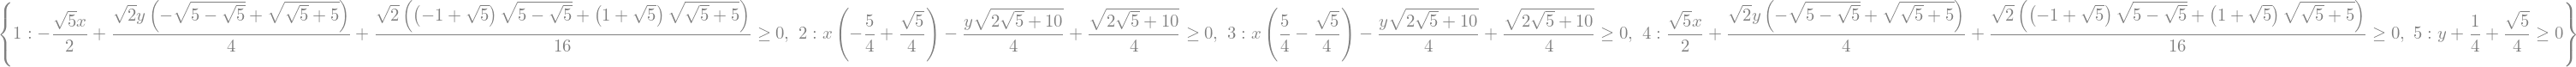

In [32]:
lines

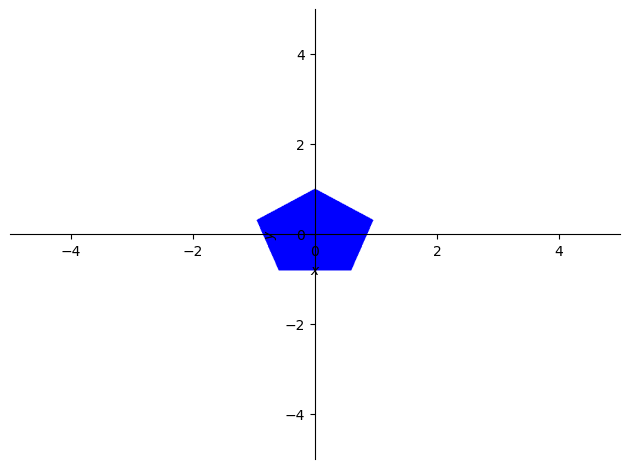

In [33]:
plot_implicit(reduce(lambda x, y: x & y, lines.values()))

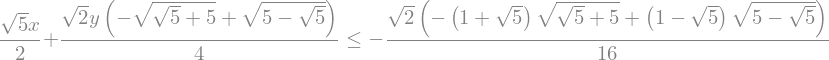

In [34]:
simplify(lines[1])

In [35]:
(5 - sqrt(5))/4 == -sqrt(5) / 2

False

In [36]:
verts: dict = dict(zip("b c d e a".split(), regpent.vertices))
verts

{'b': Point2D(sqrt(sqrt(5)/8 + 5/8), -1/4 + sqrt(5)/4),
 'c': Point2D(0, 1),
 'd': Point2D(-sqrt(sqrt(5)/8 + 5/8), -1/4 + sqrt(5)/4),
 'e': Point2D(-sqrt(5/8 - sqrt(5)/8), -sqrt(5)/4 - 1/4),
 'a': Point2D(sqrt(5/8 - sqrt(5)/8), -sqrt(5)/4 - 1/4)}

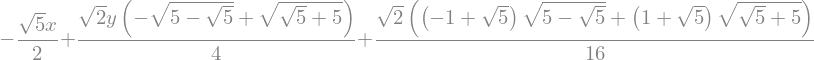

In [37]:
Line(verts["a"], verts['b']).equation()

In [38]:
vert_names = "a b c d e".split()
vert_names

['a', 'b', 'c', 'd', 'e']

In [39]:
vert_pairs = list(zip(vert_names, vert_names[1:] + vert_names[0:1]))
vert_pairs

[('a', 'b'), ('b', 'c'), ('c', 'd'), ('d', 'e'), ('e', 'a')]

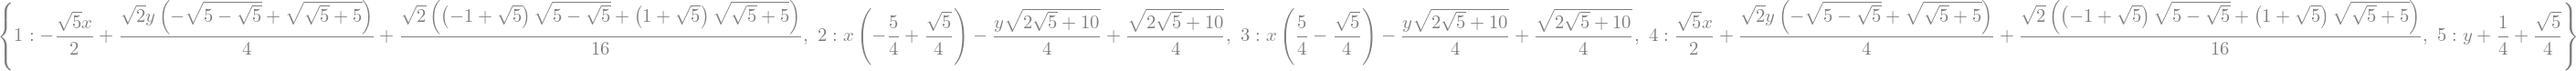

In [40]:
lines: dict = {}
for i, (vert1, vert2) in enumerate(vert_pairs, 1):
    lines[i] = build_line(x, y, Line(verts[vert1], verts[vert2]).coefficients)
lines

In [41]:
line_e = build_line(x, y, Line(verts[-1], verts[-2]).coefficients)
line_e

KeyError: -1

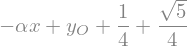

In [191]:
line_e_relative = line_e.subs("x", xo - x).subs("y", yo - alpha*x)
line_e_relative

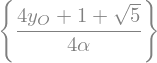

In [192]:
solveset(line_e_relative, x)

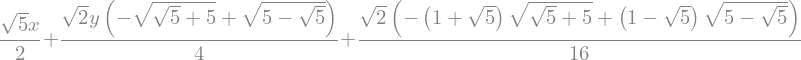

In [178]:
linea = build_line(x, y, Line(verts[0], verts[-1]).coefficients)
linea

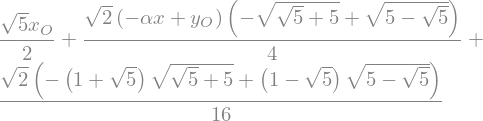

In [183]:
linea_relative = linea.subs("x", xo - x).subs("y", yo - alpha*x)
linea_relative

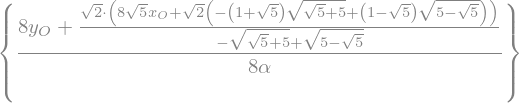

In [186]:
solveset(linea_relative, x)

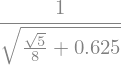

In [182]:
# picking this yields some coords = 0 or 1 but others are even worse
scaling = 1 / sqrt(sqrt(5)/8 + 5/8 )
scaling

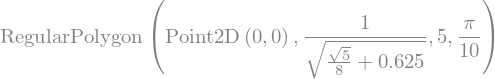

In [99]:
unitpent = sympy.RegularPolygon(Point2D(0, 0), scaling, 5, pi/2)
unitpent

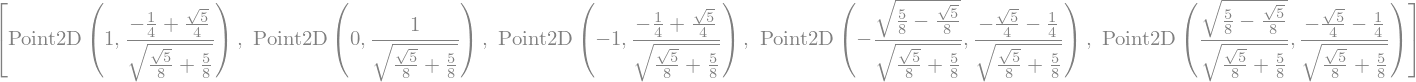

In [100]:
unitpent.vertices

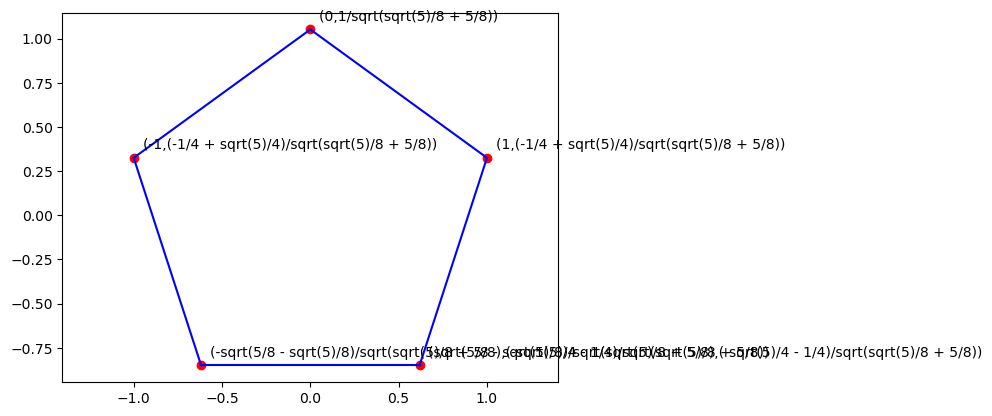

In [101]:
plot_polygon(unitpent)

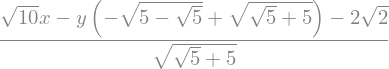

In [104]:
verts = unitpent.vertices
simplify(Line(verts[0], verts[-1]).equation())

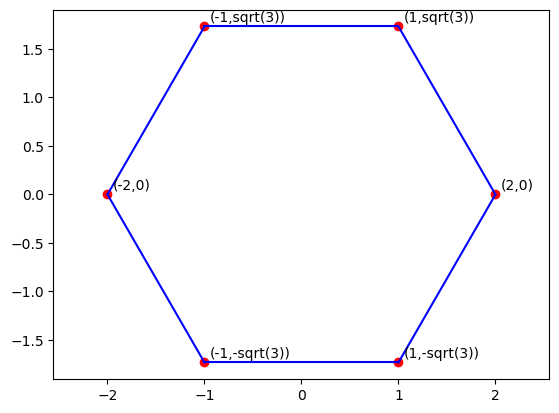

In [89]:
unithex = sympy.RegularPolygon(Point2D(0, 0), 2, 6, 0)
plot_polygon(unithex)

## Building PVS Lemma

target code:

    SoundnessAlpha(xo, yo, alpha: real) : bool =
    (EXISTS (x : real) :
    ((xo - x) <= 1 AND (xo - x) >= -1 AND
    (yo - alpha*x) <= 1 AND (yo - alpha*x) >= -1))
    IMPLIES
    ((yo - alpha*xo - alpha - 1) *
    (yo - alpha*xo + alpha + 1) <= 0) OR
    ((yo - alpha*xo - alpha + 1) *
    (yo - alpha*xo + alpha - 1) <= 0)
    OR inactive_case 
    
assume we get the pairs of active corners from the user     

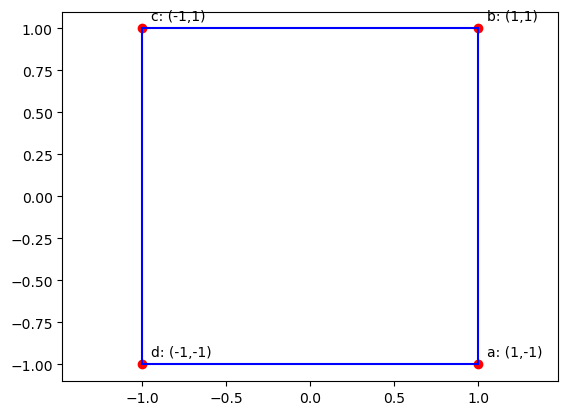

{'b': Point2D(1, 1),
 'c': Point2D(-1, 1),
 'd': Point2D(-1, -1),
 'a': Point2D(1, -1)}

In [42]:
square = RegularPolygon(Point2D(0, 0), sqrt(2), 4, pi/4)
plot_polygon(square, "b c d a".split())
square.vertices
verts, lines = verts_and_lines("b c d a".split(), square)
verts

In [43]:
lines

In [44]:
lines_rel = make_relative(lines)
lines_rel

TypeError: make_relative() missing 1 required positional argument: 'traj_expr'

In [45]:
premise = True
for line_rel in lines_rel.values():
    premise &= line_rel
premise

NameError: name 'lines_rel' is not defined

In [423]:
sympy_to_pvs(str(premise))

'(-x + xo + 1 >= 0) AND (-x + xo - 1 <= 0) AND (-alpha*x + yo + 1 >= 0) AND (-alpha*x + yo - 1 <= 0)'

In [443]:
corner_pairs = [('a', 'c'), ('b', 'd')]

In [444]:
base_traj = y - alpha*x
base_traj

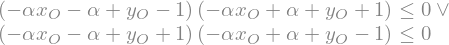

In [445]:
explicit = False
for c1, c2 in corner_pairs:
    corner_traj_1 = expand(base_traj.subs(y, yo - verts[c1].y).subs(x, xo - verts[c1].x))
    corner_traj_2 = expand(base_traj.subs(y, yo - verts[c2].y).subs(x, xo - verts[c2].x))
    pair_clause = corner_traj_1 * corner_traj_2 <= 0
    explicit |= pair_clause
explicit

In [446]:
str(explicit)

'((-alpha*x_O - alpha + y_O - 1)*(-alpha*x_O + alpha + y_O + 1) <= 0) | ((-alpha*x_O - alpha + y_O + 1)*(-alpha*x_O + alpha + y_O - 1) <= 0)'

In [451]:
sympy_to_pvs(clause)

'(-x + xo + 1 >= 0) AND (-x + xo - 1 <= 0) AND (-alpha*x + yo + 1 >= 0) AND (-alpha*x + yo - 1 <= 0)'

In [452]:
vert_names = "b c d a".split()
corner_pairs = [('a', 'c'), ('b', 'd')]
traj = y - alpha*x

In [455]:
print(full_lemma(square, vert_names, corner_pairs, traj))

Soundness(xo, yo, alpha: real) : bool =
    (EXISTS (x : real) :
    ((-x + xo + 1 >= 0) AND (-x + xo - 1 <= 0) AND (-alpha*x + yo + 1 >= 0) AND (-alpha*x + yo - 1 <= 0))
    IMPLIES
    ((-alpha*xo - alpha + yo - 1)*(-alpha*xo + alpha + yo + 1) <= 0) OR ((-alpha*xo - alpha + yo + 1)*(-alpha*xo + alpha + yo - 1) <= 0)
    


In [433]:
print(construct_lemma(premise, explicit, "SoundnessSquare"))

SoundnessSquare(xo, yo, alpha: real) : bool =
    (EXISTS (x : real) :
    ((-x + xo + 1 >= 0) AND (-x + xo - 1 <= 0) AND (-alpha*x + yo + 1 >= 0) AND (-alpha*x + yo - 1 <= 0))
    IMPLIES
    ((-alpha*xo - alpha + yo - 1)*(-alpha*xo + alpha + yo + 1) <= 0) OR ((-alpha*xo - alpha + yo + 1)*(-alpha*xo + alpha + yo - 1) <= 0)
    


## Hexagon

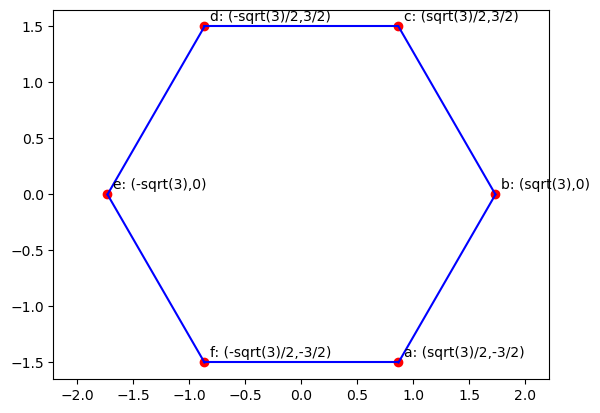

{'b': Point2D(sqrt(3), 0),
 'c': Point2D(sqrt(3)/2, 3/2),
 'd': Point2D(-sqrt(3)/2, 3/2),
 'e': Point2D(-sqrt(3), 0),
 'f': Point2D(-sqrt(3)/2, -3/2),
 'a': Point2D(sqrt(3)/2, -3/2)}

In [67]:
hexagon = RegularPolygon(Point2D(0, 0), sqrt(3), 6, 0)
plot_polygon(hexagon, "b c d e f a".split())
hexagon.vertices
verts, lines = verts_and_lines("b c d e f a".split(), hexagon)
verts

## Rectangle

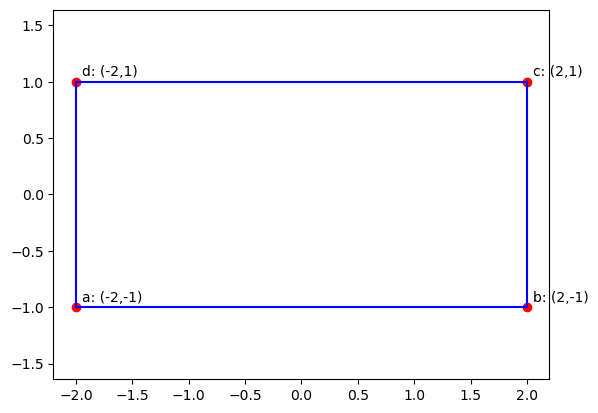

In [72]:
rectverts = [(2, -1), (2, 1), (-2, 1), (-2, -1)]
rect = Polygon(*rectverts)
plot_polygon(rect, "b c d a".split())

In [73]:
vert_names = "b c d a".split()
corner_pairs = [('a', 'c'), ('b', 'd')]
traj = y - alpha*x

In [74]:
print(full_lemma(rect, vert_names, corner_pairs, traj))

Soundness(xo, yo, alpha: real) : bool =
    (EXISTS (x : real) :
    ((-x + xo + 2 >= 0) AND
     (-x + xo - 2 <= 0) AND
     (-alpha*x + yo + 1 >= 0) AND
     (-alpha*x + yo - 1 <= 0))
    IMPLIES
    ((-alpha*xo - 2*alpha + yo - 1)*(-alpha*xo + 2*alpha + yo + 1) <= 0) OR
    ((-alpha*xo - 2*alpha + yo + 1)*(-alpha*xo + 2*alpha + yo - 1) <= 0)
    


## Diamond

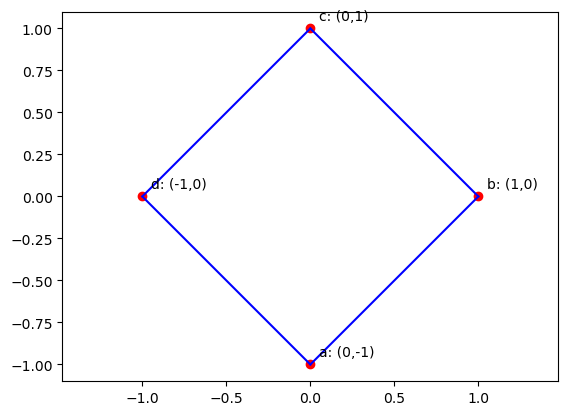

{'b': Point2D(1, 0),
 'c': Point2D(0, 1),
 'd': Point2D(-1, 0),
 'a': Point2D(0, -1)}

In [80]:
diamond = RegularPolygon(Point2D(0, 0), 1, 4, 0)
plot_polygon(diamond, "b c d a".split())
diamond.vertices
verts, lines = verts_and_lines("b c d a".split(), diamond)
verts

In [81]:
vert_names = "b c d a".split()
corner_pairs = [('a', 'c'), ('b', 'd')]
traj = y - x**2
traj_expr = x**2

In [82]:
traj

note: are we missing the notch here???

In [83]:
print(full_lemma(diamond, vert_names, corner_pairs, traj, traj_expr))

Soundness(xo, yo, alpha: real) : bool =
    (EXISTS (x : real) :
    ((-x^2 - x + xo + yo + 1 >= 0) AND
     (-x^2 + x - xo + yo + 1 >= 0) AND
     (x^2 - x + xo - yo + 1 >= 0) AND
     (x^2 + x - xo - yo + 1 >= 0))
    IMPLIES
    ((-xo^2 + yo - 1)*(-xo^2 + yo + 1) <= 0) OR
    ((-xo^2 - 2*xo + yo - 1)*(-xo^2 + 2*xo + yo - 1) <= 0)
    


## Square

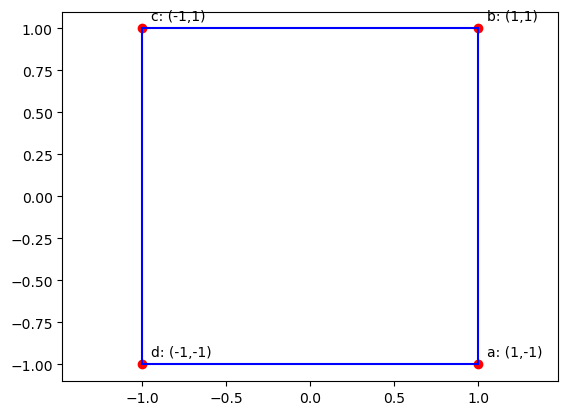

{'b': Point2D(1, 1),
 'c': Point2D(-1, 1),
 'd': Point2D(-1, -1),
 'a': Point2D(1, -1)}

In [89]:
square = RegularPolygon(Point2D(0, 0), sqrt(2), 4, pi/4)
plot_polygon(square, "b c d a".split())
verts, lines = verts_and_lines("b c d a".split(), square)
verts

In [90]:
vert_names = "b c d a".split()
corner_pairs = [('a', 'c'), ('b', 'd')]
traj = y - alpha*x
traj_expr = alpha*x

In [91]:
print(full_lemma(square, vert_names, corner_pairs, traj, traj_expr))

Soundness(xo, yo, alpha: real) : bool =
    (EXISTS (x : real) :
    ((-x + xo + 1 >= 0) AND
     (-x + xo - 1 <= 0) AND
     (-alpha*x + yo + 1 >= 0) AND
     (-alpha*x + yo - 1 <= 0))
    IMPLIES
    ((-alpha*xo - alpha + yo - 1)*(-alpha*xo + alpha + yo + 1) <= 0) OR
    ((-alpha*xo - alpha + yo + 1)*(-alpha*xo + alpha + yo - 1) <= 0)
    
